In [ ]:
%pip install segment-geospatial leafmap localtileserver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import leafmap
import torch
from samgeo import SamGeo, tms_to_geotiff

In [ ]:
m = leafmap.Map(center=[-6.901654, 107.6846897], zoom=19)
m.add_basemap('SATELLITE')
m
if m.user_roi_bounds() is not None:
 bbox = m.user_roi_bounds()
else:
 bbox = [-6.901491, 107.8467423, -6.902232, 107.847544]

In [ ]:
image = '/content/Clipdustin4.tif'
# image = '/path/to/your/own/image.tif'
tms_to_geotiff(output=image, bbox=bbox, zoom=20, source='Satellite')
m.add_raster(image, layer_name='Image')
m

The output file /content/Clipdustin4.tif already exists. Use `overwrite=True` to overwrite it.


Map(center=[-6.901654, 107.6846897], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [ ]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
checkpoint = os.path.join(out_dir, 'sam_vit_h_4b8939.pth')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam = SamGeo(
    checkpoint=checkpoint,
    model_type='vit_h',
    device=device,
    erosion_kernel=(3, 3),
    mask_multiplier=255,
    sam_kwargs=None,
)

In [ ]:
mask = 'segmentITB.tiff'
sam.generate(image, mask)
#Polygonize the raster data( Save the segmentation results as a GeoPackage or vector file).
vector = 'segmentITB.gpkg'
sam.tiff_to_gpkg(mask, vector, simplify_tolerance=None)
shapefile = 'segmentITB.shp'
sam.tiff_to_vector(mask, shapefile)

100%|██████████| 1/1 [00:08<00:00,  8.24s/it]


In [ ]:
style = {
 'color': '#0000ff',
 'weight': 2,
 'fillColor': '#7c4185',
 'fillOpacity': 0.3,
}
m.add_vector(vector, layer_name='Vector', style=style)
m


Map(center=[-6.8892964555, 107.61068134749999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zo…

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
 if len(anns) == 0:
     return
 sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
 ax = plt.gca()
 ax.set_autoscale_on(False)
 polygons = []
 color = []
 for ann in sorted_anns:
      m = ann['segmentation']
      img = np.ones((m.shape[0], m.shape[1], 3))
      color_mask = np.random.random((1, 3)).tolist()[0]
      for i in range(3):
        img[:,:,i] = color_mask[i]
      ax.imshow(np.dstack((img, m*0.35)))


In [ ]:
import sys
import os
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
checkpoint = os.path.join(out_dir, 'sam_vit_h_4b8939.pth')

In [ ]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
checkpoint = os.path.join(out_dir, 'sam_vit_h_4b8939.pth')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
 model=sam,
 points_per_side=32,
 pred_iou_thresh=0.86,
 stability_score_thresh=0.92,
 crop_n_layers=1,
 crop_n_points_downscale_factor=2, 
 min_mask_region_area=100, # Requires open-cv to run postprocessing
)

In [ ]:
from PIL import Image
# Membuka gambar dalam format TIFF
with Image.open('/content/Clipdustin3.tif') as img:
 # Mengonversi gambar ke format RGB
 img = img.convert('RGB')
 # Menyimpan gambar dalam format PNG
 img.save('Sample2.jpg')

In [ ]:
image = cv2.imread('/content/Sample2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

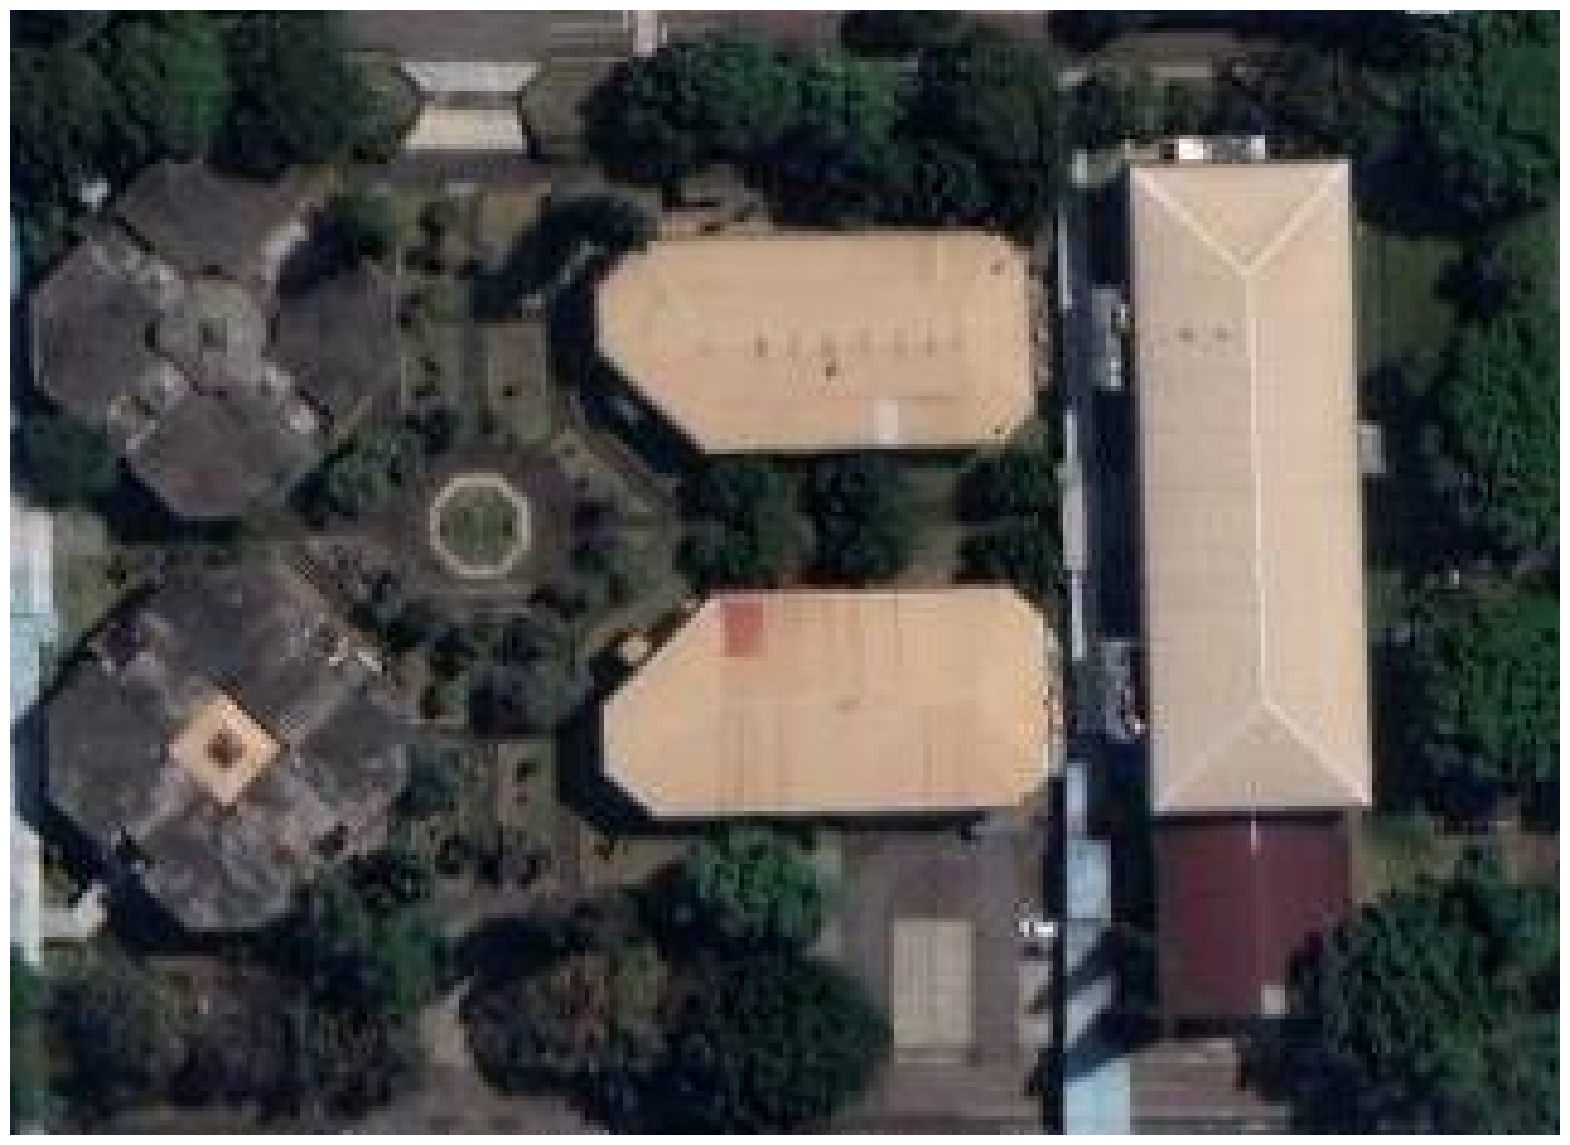

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
masks = mask_generator.generate(image)
print(len(masks))
print(masks[0].keys())

104
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


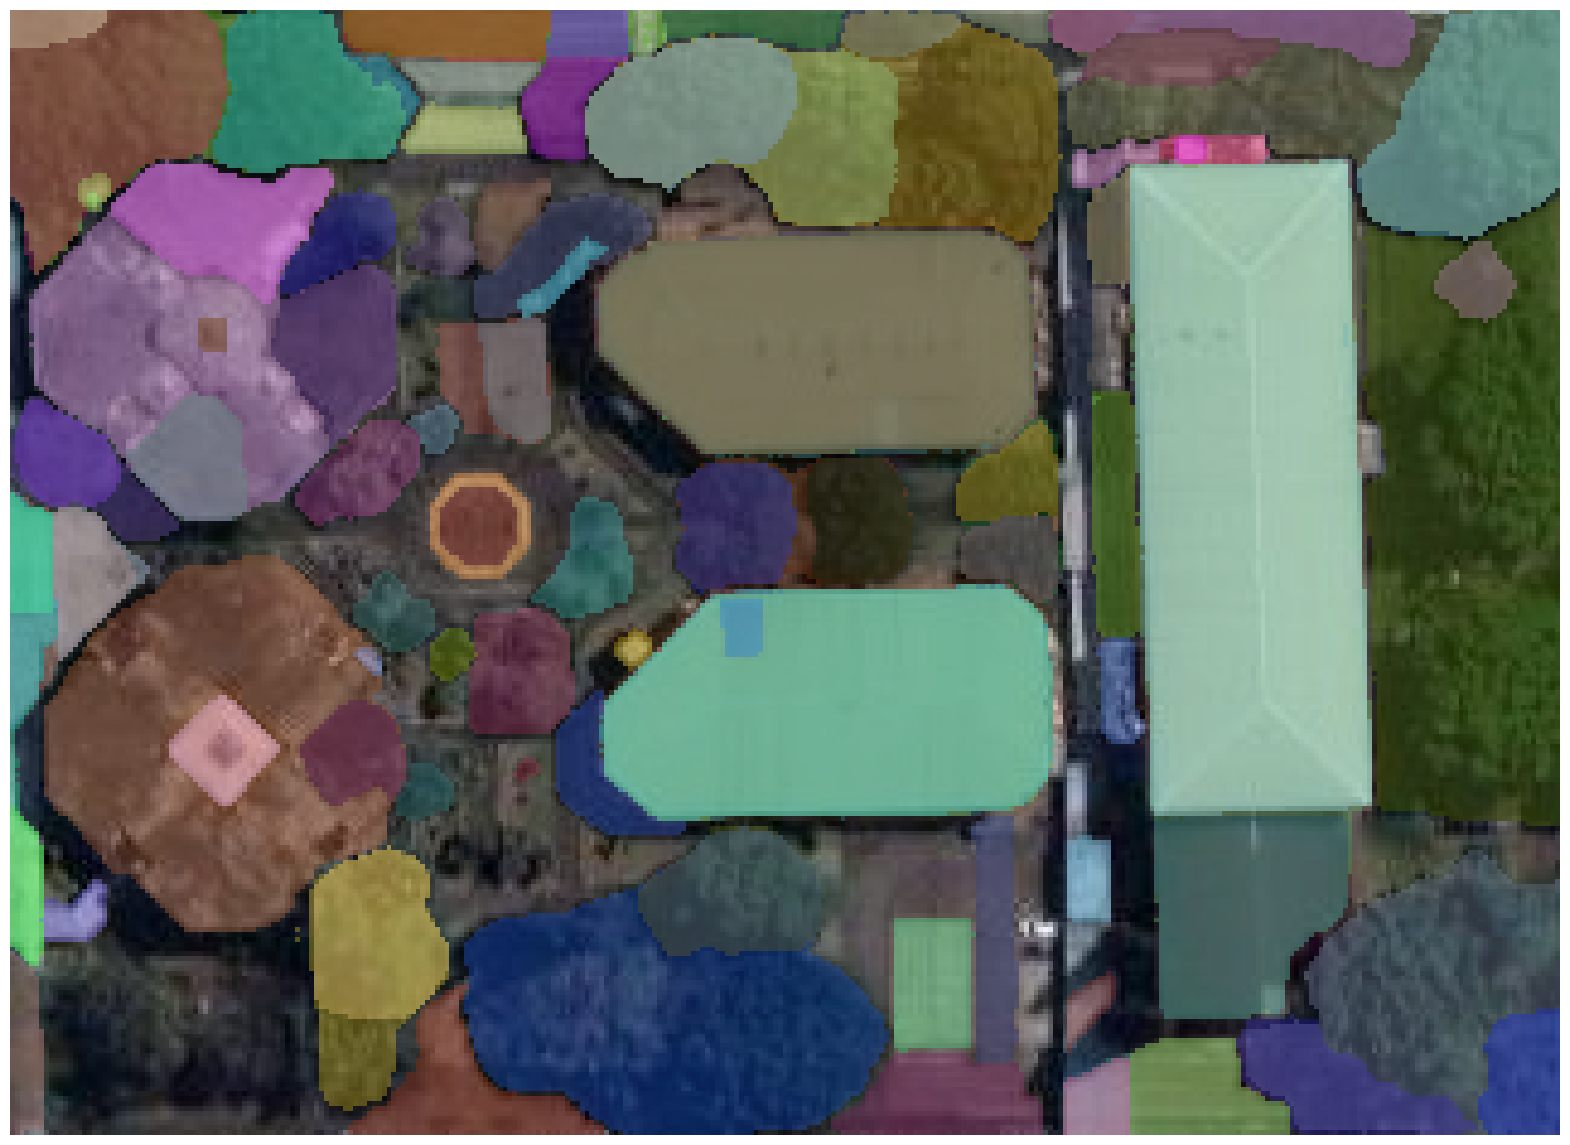

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
masks2 = mask_generator_2.generate(image)

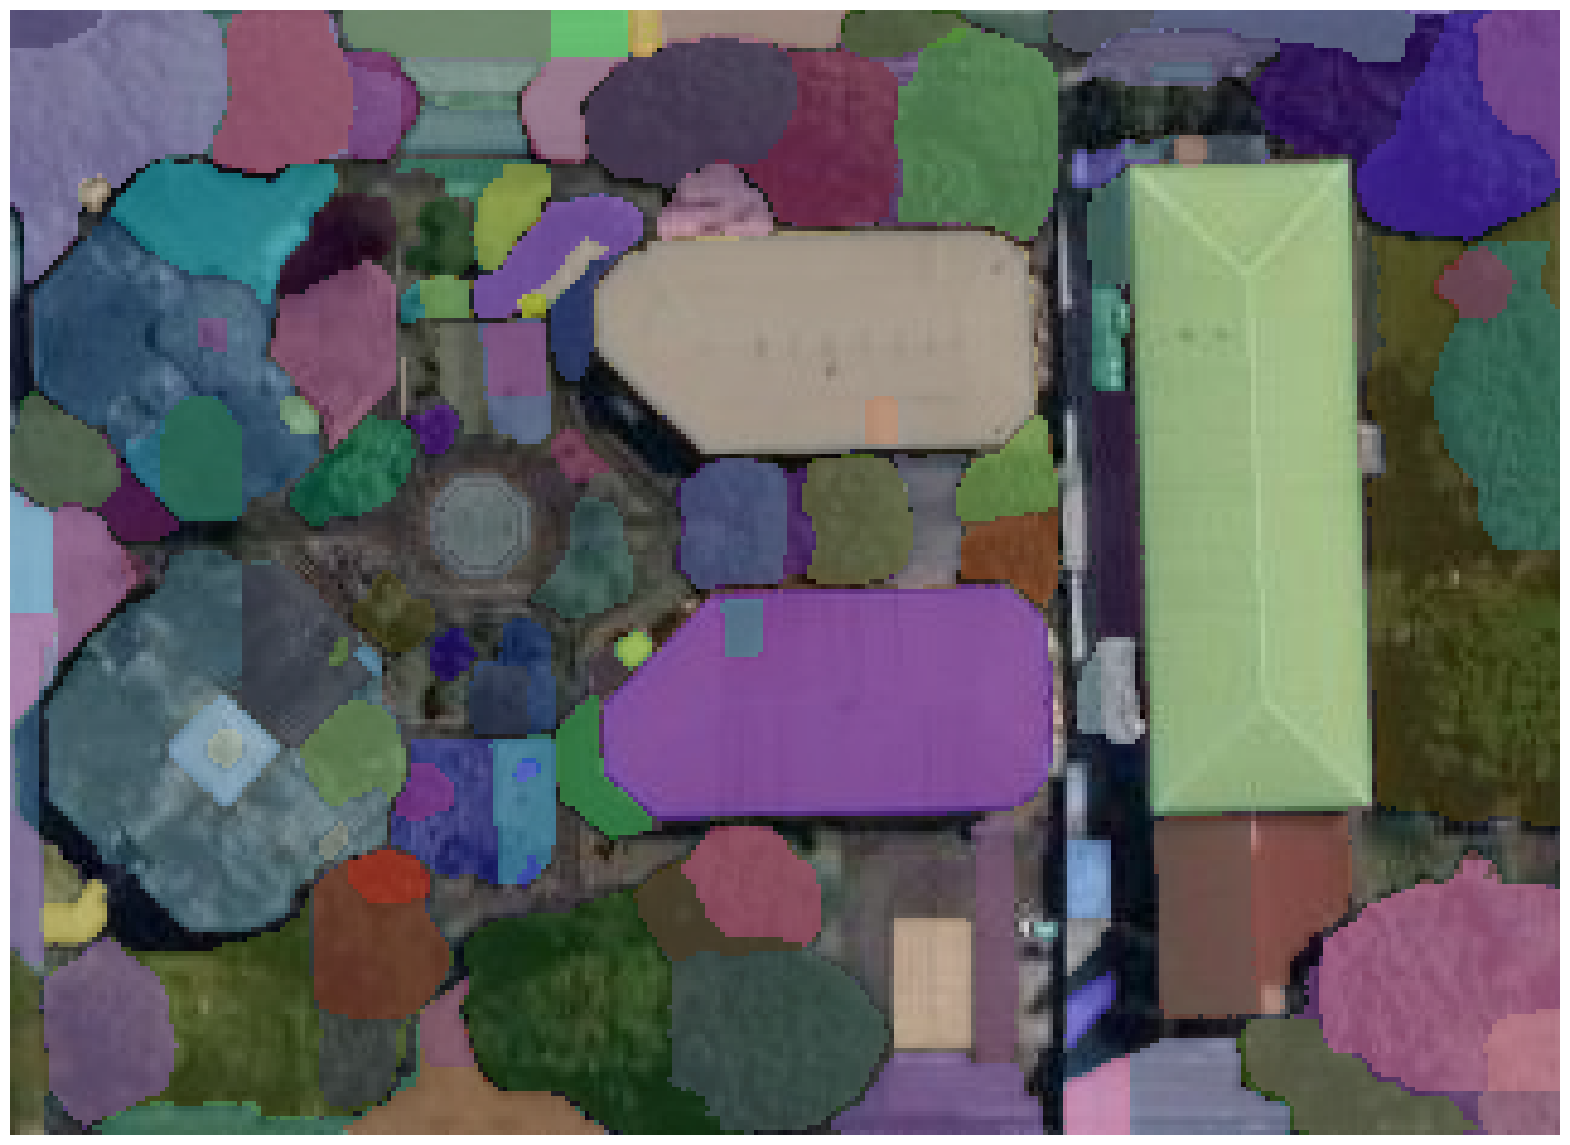

In [ ]:

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()